In [1]:
import numpy as np
import pandas as pd
from stocktrends import Renko
import statsmodels.api as sm
from alpha_vantage.timeseries import TimeSeries
import copy
import datetime as dt
import yfinance as yf

In [2]:
def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["Close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["Close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    return (df["MACD"],df["Signal"])

In [3]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

In [4]:
def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

In [5]:
def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

In [6]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

In [7]:
def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

In [8]:
def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

In [9]:
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [32]:
spy=pd.read_csv("SPY_intraday.csv")
spy.index=pd.to_datetime(spy["Datetime"])
spy.drop("Datetime",axis=1,inplace=True)

In [33]:
spy

,Open,High,Low,Close,Volume,hours
Datetime,,,,,,
2005-01-03 09:30:00,87.0610,87.1326,87.0109,87.1111,1251700,intraday
2005-01-03 09:35:00,87.1111,87.2042,87.0968,87.1827,934900,intraday
2005-01-03 09:40:00,87.1541,87.1684,87.0968,87.1326,865500,intraday
2005-01-03 09:45:00,87.1326,87.1684,87.0753,87.0968,584700,intraday
2005-01-03 09:50:00,87.1326,87.1326,87.0180,87.0180,621600,intraday
...,...,...,...,...,...,...
2022-11-25 15:30:00,402.3600,402.3600,402.3600,402.3600,100,intraday
2022-11-25 15:35:00,402.4800,402.4800,402.4800,402.4800,900,intraday
2022-11-25 15:40:00,402.4800,402.4800,402.3900,402.3900,611,intraday


In [34]:
renko_DF(spy)

/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_70052/2866808216.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_70052/2866808216.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]


,date,open,high,low,close,uptrend,bar_num
0,2005-01-03 09:30:00,86.5,87.0,86.5,87.0,True,1
1,2005-01-03 15:30:00,86.5,86.5,86.0,86.0,False,-1
2,2005-01-04 14:05:00,86.0,86.0,85.5,85.5,False,-2
3,2005-01-04 14:45:00,85.5,85.5,85.0,85.0,False,-3
4,2005-01-12 09:50:00,85.0,85.0,84.5,84.5,False,-4
...,...,...,...,...,...,...,...
24327,2022-11-23 12:55:00,400.5,400.5,400.0,400.0,False,-3
24328,2022-11-23 13:40:00,400.5,401.0,400.5,401.0,True,1
24331,2022-11-23 14:00:00,402.0,402.5,402.0,402.5,True,4
24332,2022-11-23 14:35:00,402.0,402.0,401.5,401.5,False,-1


In [35]:
renko = renko_DF(spy)
renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
spy["Date"] = spy.index
spy = spy.merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
spy["bar_num"].fillna(method='ffill',inplace=True)
spy["macd"]= MACD(spy,12,26,9)[0]
spy["macd_sig"]= MACD(spy,12,26,9)[1]
spy["macd_slope"] = slope(spy["macd"],5)
spy["macd_sig_slope"] = slope(spy["macd_sig"],5)

/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_70052/2866808216.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_70052/2866808216.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]


In [36]:
spy

,Open,High,Low,Close,Volume,hours,Date,bar_num,macd,macd_sig,macd_slope,macd_sig_slope
0,87.0610,87.1326,87.0109,87.1111,1251700,intraday,2005-01-03 09:30:00,1.0,NaN,NaN,0.000000,0.000000
1,87.1111,87.2042,87.0968,87.1827,934900,intraday,2005-01-03 09:35:00,1.0,NaN,NaN,0.000000,0.000000
2,87.1541,87.1684,87.0968,87.1326,865500,intraday,2005-01-03 09:40:00,1.0,NaN,NaN,0.000000,0.000000
3,87.1326,87.1684,87.0753,87.0968,584700,intraday,2005-01-03 09:45:00,1.0,NaN,NaN,0.000000,0.000000
4,87.1326,87.1326,87.0180,87.0180,621600,intraday,2005-01-03 09:50:00,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
351264,402.3600,402.3600,402.3600,402.3600,100,intraday,2022-11-25 15:30:00,1.0,0.019967,0.022637,-4.380225,39.048197
351265,402.4800,402.4800,402.4800,402.4800,900,intraday,2022-11-25 15:35:00,1.0,0.024276,0.022965,-28.059276,32.473336
351266,402.4800,402.4800,402.3900,402.3900,611,intraday,2022-11-25 15:40:00,1.0,0.020196,0.022411,-36.358320,-14.570985
351267,402.4700,402.4700,402.3500,402.3500,1023,intraday,2022-11-25 15:50:00,1.0,0.013579,0.020644,-38.409204,-39.826637


In [37]:
spy.index=spy.Date

In [38]:
spy

,Open,High,Low,Close,Volume,hours,Date,bar_num,macd,macd_sig,macd_slope,macd_sig_slope
Date,,,,,,,,,,,,
2005-01-03 09:30:00,87.0610,87.1326,87.0109,87.1111,1251700,intraday,2005-01-03 09:30:00,1.0,NaN,NaN,0.000000,0.000000
2005-01-03 09:35:00,87.1111,87.2042,87.0968,87.1827,934900,intraday,2005-01-03 09:35:00,1.0,NaN,NaN,0.000000,0.000000
2005-01-03 09:40:00,87.1541,87.1684,87.0968,87.1326,865500,intraday,2005-01-03 09:40:00,1.0,NaN,NaN,0.000000,0.000000
2005-01-03 09:45:00,87.1326,87.1684,87.0753,87.0968,584700,intraday,2005-01-03 09:45:00,1.0,NaN,NaN,0.000000,0.000000
2005-01-03 09:50:00,87.1326,87.1326,87.0180,87.0180,621600,intraday,2005-01-03 09:50:00,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25 15:30:00,402.3600,402.3600,402.3600,402.3600,100,intraday,2022-11-25 15:30:00,1.0,0.019967,0.022637,-4.380225,39.048197
2022-11-25 15:35:00,402.4800,402.4800,402.4800,402.4800,900,intraday,2022-11-25 15:35:00,1.0,0.024276,0.022965,-28.059276,32.473336
2022-11-25 15:40:00,402.4800,402.4800,402.3900,402.3900,611,intraday,2022-11-25 15:40:00,1.0,0.020196,0.022411,-36.358320,-14.570985


In [19]:

for i in range(len(spy)):
    if tickers_signal[ticker] == "":
        tickers_ret[ticker].append(0)
        if i > 0:
            if spy["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                tickers_signal[ticker] = "Sell"

    elif tickers_signal[ticker] == "Buy":
        tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
        if i > 0:
            if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                tickers_signal[ticker] = "Sell"
            elif ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                tickers_signal[ticker] = ""

    elif tickers_signal[ticker] == "Sell":
        tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
        if i > 0:
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                tickers_signal[ticker] = ""
ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

NameError: name 'tickers' is not defined

In [27]:
def gain_plot_data(buy_value,sell_value):
    signal_list=[]
    signal=""
    return_list=[]
    for i in range(len(spy)):
        if spy.index[i].hour==15 and spy.index[i].minute==55:
            if signal=="Buy Call":
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
            elif signal=="Buy Put":
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
            elif signal=="":
                signal_list.append("")
                return_list.append(0)
        elif signal=="":
            if spy["bar_num"][i]>=buy_value and spy["macd"][i]>spy["macd_sig"][i] and spy["macd_slope"][i]>spy["macd_sig_slope"][i]:
                signal="Buy Call"
                signal_list.append(signal)
                cost=spy["Close"][i]
                return_list.append(0)
            elif spy["bar_num"][i]<=sell_value and spy["macd"][i]<spy["macd_sig"][i] and spy["macd_slope"][i]<spy["macd_sig_slope"][i]:
                signal="Buy Put"
                signal_list.append(signal)
                cost=spy["Close"][i]
                return_list.append(0)
            else:
                signal_list.append("")
                return_list.append(0)
        elif signal=="Buy Call":
            #sell signal
            if spy["bar_num"][i]<=-2:
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
            else:
                signal_list.append("")
                return_list.append(0)

        elif signal=="Buy Put":
            #sell signal
            if spy["bar_num"][i]>=2:
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
            else:
                signal_list.append("")
                return_list.append(0)

    spy["signal"]=signal_list
    spy["return"]=return_list
    spy["return_dollar"]=spy["return"]*50
    spy["cum_return"]=spy["return_dollar"].cumsum()
    #spy['cum_return']=spy['return'].cumsum()
    return spy

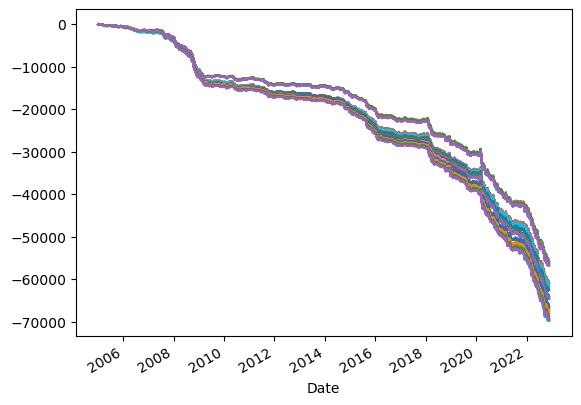

In [31]:
for i in range(1,6):
    for j in range(1,6):
        gain_plot_data(buy_value=i,sell_value=j)["cum_return"].plot()

In [22]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
print(CAGR(strategy_df))
print(sharpe(strategy_df,0.025))
print(max_dd(strategy_df))  

1.98789648682382
7.95976062317749
0.07575199038306948


<AxesSubplot:>

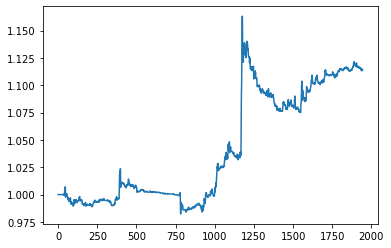

In [23]:
#visualizing strategy returns
(1+strategy_df["ret"]).cumprod().plot()

In [25]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

calculating KPIs for  AMC
calculating KPIs for  GME
calculating KPIs for  TSLA


In [26]:
KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
AMC,8.043043,15.602451,0.167564
GME,2.913931,7.726348,0.084428
TSLA,-0.332223,-1.997873,0.068132
